# Bob.FM Hardware FIR Filter

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as signal
from scipy.fftpack import fft, ifft, fftfreq

In [2]:
def signal_gen(frequency=0.5, amplitude=1, phase_degrees=0, duration=1, 
               sampling_freq=1):
    """A signal generator"""
    phase = phase_degrees * np.pi/180
    try:
        time  = np.arange(0,duration, 1/sampling_freq) # X axis: Time & Samples
    except MemoryError as err:
        print("Please set a shorter duration or smaller sampling frequency")
        time  = np.arange(0,3/frequency, 1/sampling_freq) # X axis: Time & Samples
    
    return time, amplitude*np.sin(2*np.pi*frequency*time+phase)

def dB(voltage):
    """Converts voltage to dB"""
    return 20 * np.log10(voltage)

def rthomp_fft(signal, sampling_freq):
    """Performs an FFT on the signal provided"""
    nfft       = int(5*2**(np.ceil(np.log2(len(signal))))) # Deligating freq bings
    signal_fft = fft(signal, nfft)/len(signal)             # Perform FFT
    fft_freq   = fftfreq(nfft, 1/sampling_freq)            # Extract frequencies
    
    # Taking the magnitude and sectioning off the imag. freq
    signal_fft = dB(2*abs(signal_fft[0:nfft//2]))
    fft_freq   = fft_freq[0:nfft//2]
    
    return fft_freq, signal_fft

### Signal generation

(75000000.0, 150000000.0)

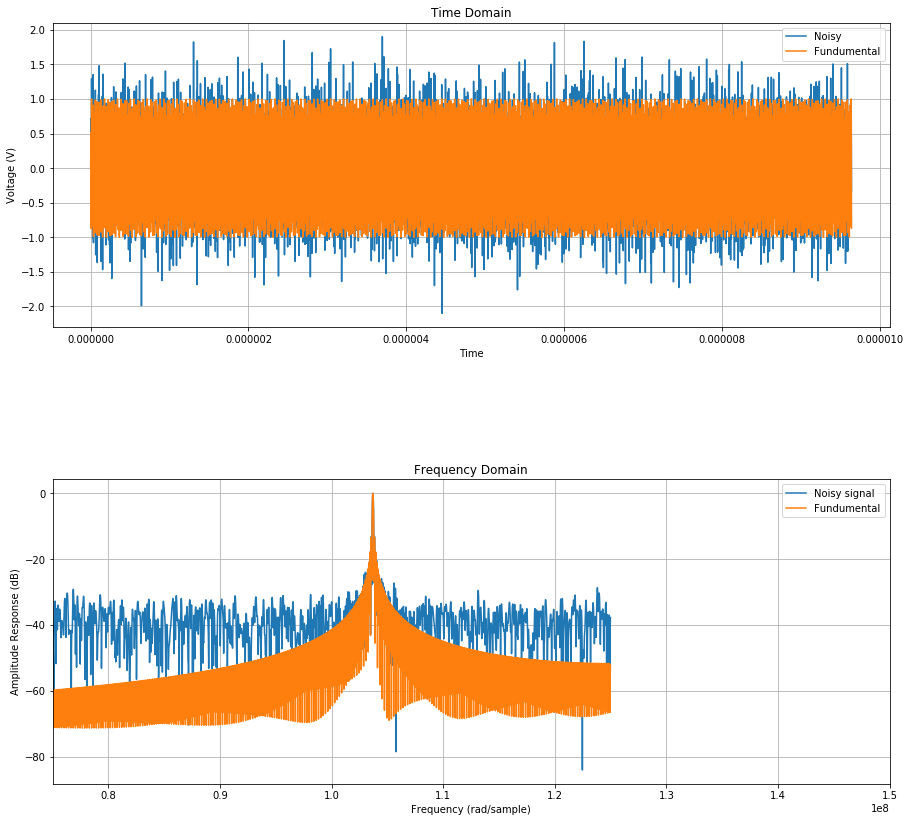

In [11]:
# Fundumental signal
freq = 103.7e6 # bob.fm station
amp = 1
Fs = 250e6
dur = 1e3/freq    # 100.1 cycles
t, s_fundumental = signal_gen(freq,sampling_freq=Fs, duration=dur, amplitude=amp)

# Gaussian noise signal with zero mean and unit variance
variance = .1
stdev = np.sqrt(variance)
noise = np.random.normal(0,stdev,np.size(t))

# Makes the signal noisy
s = s_fundumental + noise

# FFTs
nfft, S             = rthomp_fft(s, Fs)
nfft, S_fundumental = rthomp_fft(s_fundumental, Fs)

# Graph
plt.figure('position', [15,14])
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,1)
plt.title("Time Domain")
plt.plot(t, s, label='Noisy')
plt.plot(t, s_fundumental, label='Fundumental')
plt.ylabel('Voltage (V)')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.title('Frequency Domain')
plt.plot(nfft, S, label="Noisy signal")
plt.plot(nfft, S_fundumental, label="Fundumental")
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (rad/sample)')
plt.grid()
plt.legend()
plt.xlim(75e6,150e6)
# plt.ylim(-50,10)

### Filter Design
This part encapsulates the design decisions of the BOB.FM FIR filter.
            
    Center Frequency (fr): 103.7MHz
    FM Passband: 200kHz
    Sampling frequency (Fs): 250MHz
    
References: [T-Filt](http://t-filter.engineerjs.com/), [mytexttools](https://mytexttools.com/find-and-replace-text.html)

Expect a delay of 1.244e-06 seconds


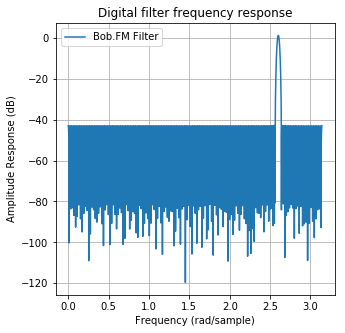

In [31]:
# Filter parameters
b = [5933295, 3323643, -3193608, 3188221, -2981368, 2377935, -1356937, 73774, 1185546, -2089668, 2366703, -1898567, 775254, 710900, -2135303, 3057788, -3153104, 2319378, -728363, -1205837, 2932816, -3919339, 3813531, -2565216, 460822, 1934065, -3927182, 4896478, -4481992, 2711870, -20196, -2855833, 5075007, -5937224, 5101278, -2708172, -630164, 3983749, -6362765, 7007600, -5627204, 2513204, 1513630, -5317534, 7766093, -8065864, 6014791, -2093994, -2641421, 6839191, -9243698, 9058085, -6212664, 1415935, 4019800, -8531656, 10755008, -9936500, 6181650, -460324, -5639827, 10352441, -12243074, 10643506, -5878810, -787884, 7486597, -12263324, 13652367, -11125099, 5270979, 2332022, -9524645, 14207135, -14924653, 11334218, -4333644, -4155291, 11714630, -16118535, 15988299, -11220263, 3055935, 6238109, -13999789, 17933927, -16789840, 10755759, -1444519, -8536676, 16315687, -19582135, 17274208, -9918021, -484798, 11000213, -18590716, 20993366, -17393312, 8694950, 2703036, -13568121, 20751468, -22102995, 17113295, -7094246, -5162857, 16166297, -22720737, 22855412, -16416074, 5142646, 7800740, -18715212, 24425681, -23205676, 15298209, -2877199, -10553075, 21134822, -25808963, 23113334, -13760111, 346400, 13333651, -23352403, 26787258, -22578303, 11852249, 2379727, -16068898, 25283130, -27338643, 21583238, -9601103, -5224080, 18665488, -26860802, 27426335, -20150864, 7068450, 8108550, -21045880, 28031543, -27037226, 18314205, -4326822, -10943280, 23134075, -28751959, 26175499, -16123879, 1456537, 13642579, -24861910, 28995601, -24861910, 13642579, 1456537, -16123879, 26175499, -28751959, 23134075, -10943280, -4326822, 18314205, -27037226, 28031543, -21045880, 8108550, 7068450, -20150864, 27426335, -26860802, 18665488, -5224080, -9601103, 21583238, -27338643, 25283130, -16068898, 2379727, 11852249, -22578303, 26787258, -23352403, 13333651, 346400, -13760111, 23113334, -25808963, 21134822, -10553075, -2877199, 15298209, -23205676, 24425681, -18715212, 7800740, 5142646, -16416074, 22855412, -22720737, 16166297, -5162857, -7094246, 17113295, -22102995, 20751468, -13568121, 2703036, 8694950, -17393312, 20993366, -18590716, 11000213, -484798, -9918021, 17274208, -19582135, 16315687, -8536676, -1444519, 10755759, -16789840, 17933927, -13999789, 6238109, 3055935, -11220263, 15988299, -16118535, 11714630, -4155291, -4333644, 11334218, -14924653, 14207135, -9524645, 2332022, 5270979, -11125099, 13652367, -12263324, 7486597, -787884, -5878810, 10643506, -12243074, 10352441, -5639827, -460324, 6181650, -9936500, 10755008, -8531656, 4019800, 1415935, -6212664, 9058085, -9243698, 6839191, -2641421, -2093994, 6014791, -8065864, 7766093, -5317534, 1513630, 2513204, -5627204, 7007600, -6362765, 3983749, -630164, -2708172, 5101278, -5937224, 5075007, -2855833, -20196, 2711870, -4481992, 4896478, -3927182, 1934065, 460822, -2565216, 3813531, -3919339, 2932816, -1205837, -728363, 2319378, -3153104, 3057788, -2135303, 710900, 775254, -1898567, 2366703, -2089668, 1185546, 73774, -1356937, 2377935, -2981368, 3188221, -3193608, 3323643, 5933295]
a = 2**31

print('Expect a delay of '+ str(len(b)/Fs) +' seconds')
nfft   = int(5*2**(np.ceil(np.log2(len(s)))))
w, response = signal.freqz(b, a, worN=nfft)

# Frequency Response
plt.figure('position', [5,5])
plt.title('Digital filter frequency response')
plt.plot(w, 20 * np.log10(abs(response)), label='Bob.FM Filter')
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (rad/sample)')
plt.grid()
plt.legend()

### Applying the filter

Now that we have the filter's zeroes, we'll apply it on a random signal to see if it works.

(90000000.0, 120000000.0)

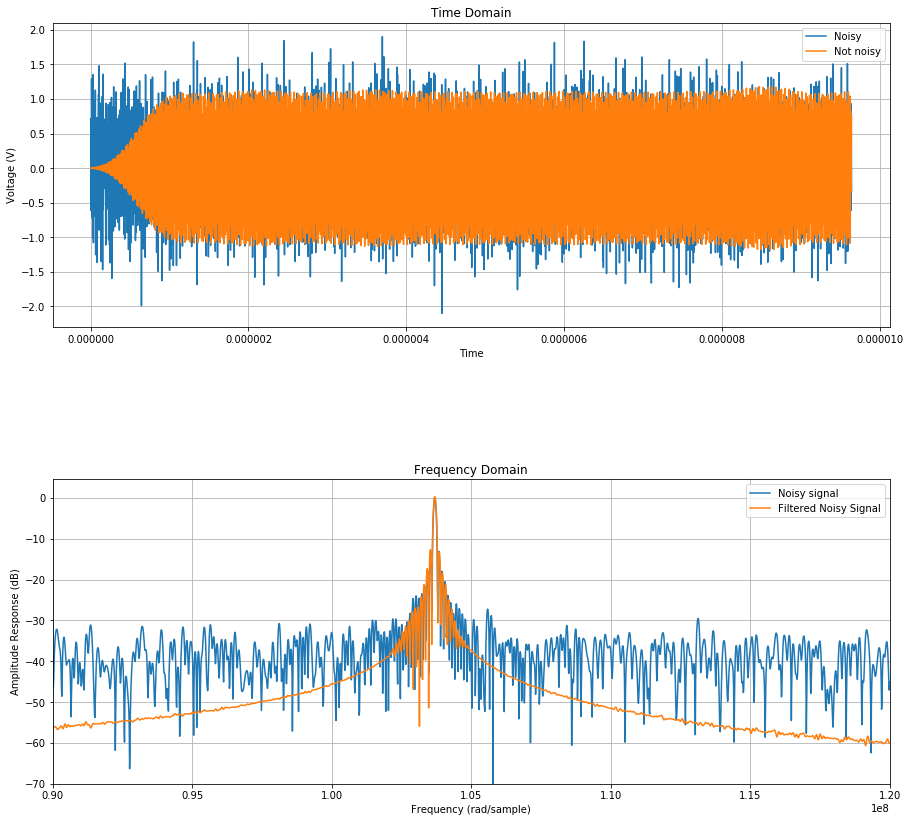

In [32]:
# Filter applied
s_filt = signal.lfilter(b,a,s)

# FFTs
nfft, S = rthomp_fft(s,Fs)
nfft, S_filt = rthomp_fft(s_filt, Fs)

# Graph
plt.figure('position', [15,14])
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,1)
plt.title("Time Domain")
plt.plot(t, s, label='Noisy')
plt.plot(t, s_filt, label='Not noisy')
plt.ylabel('Voltage (V)')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.title('Frequency Domain')
plt.plot(nfft, S, label="Noisy signal")
plt.plot(nfft, S_filt, label="Filtered Noisy Signal")
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (rad/sample)')
plt.grid()
plt.legend()
plt.ylim(-70)
plt.xlim(90e6,120e6)